First 5 rows of dataset:
   Gender  Occupation BMI Category Sleep Disorder  Age  Sleep Duration  \
0    Male      Doctor       Normal    Sleep Apnea   50             7.0   
1  Female       Nurse       Normal            NaN   34             6.0   
2    Male  Accountant       Normal            NaN   56             6.0   
3  Female     Teacher       Normal            NaN   40             7.0   
4  Female  Accountant       Normal    Sleep Apnea   43             6.0   

   Quality of Sleep  Physical Activity Level  Stress Level  Heart Rate  \
0               5.0                       30           7.0        65.0   
1               7.0                       55           4.0        74.0   
2               6.0                       62           6.0        78.0   
3               8.0                       69           4.0        68.0   
4               8.0                       61           4.0        72.0   

   Daily Steps  Systolic BP  Diastolic BP  
0       6207.0        129.0          80.0

<Figure size 1200x600 with 0 Axes>

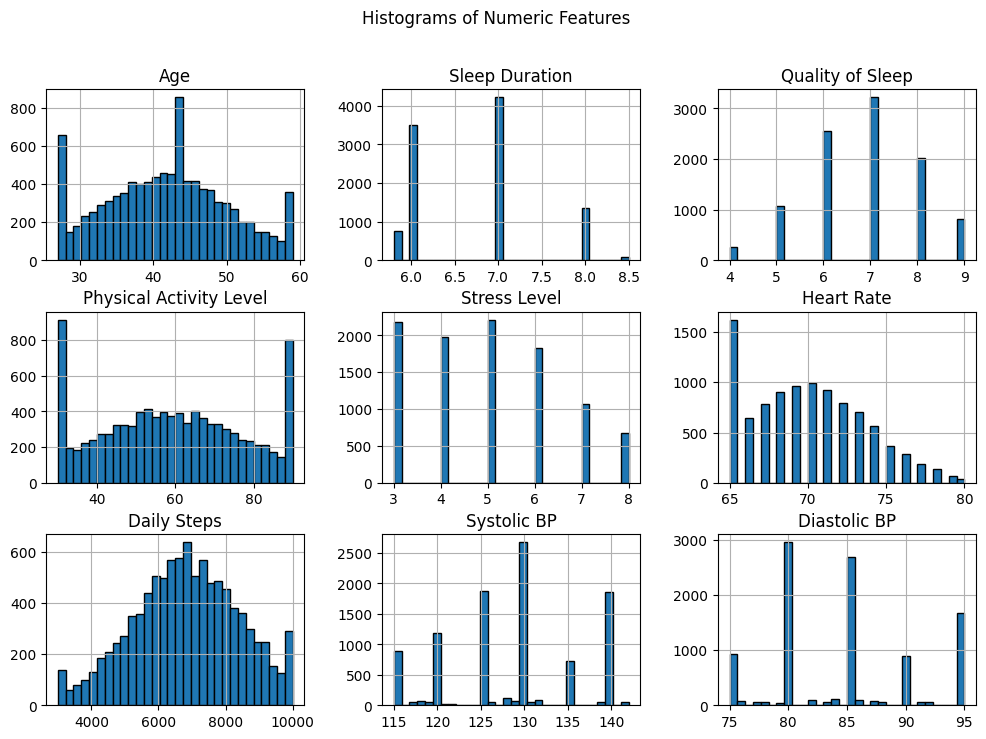

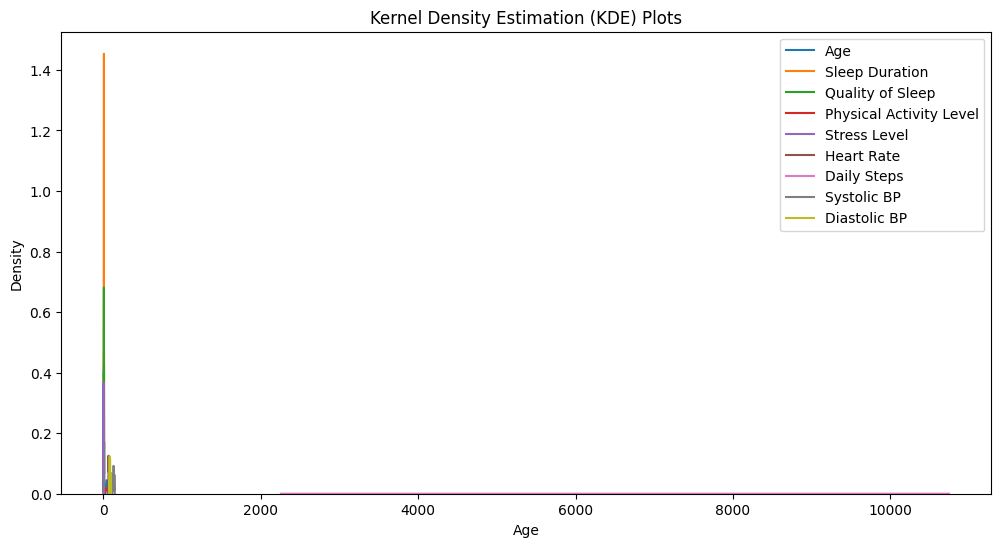

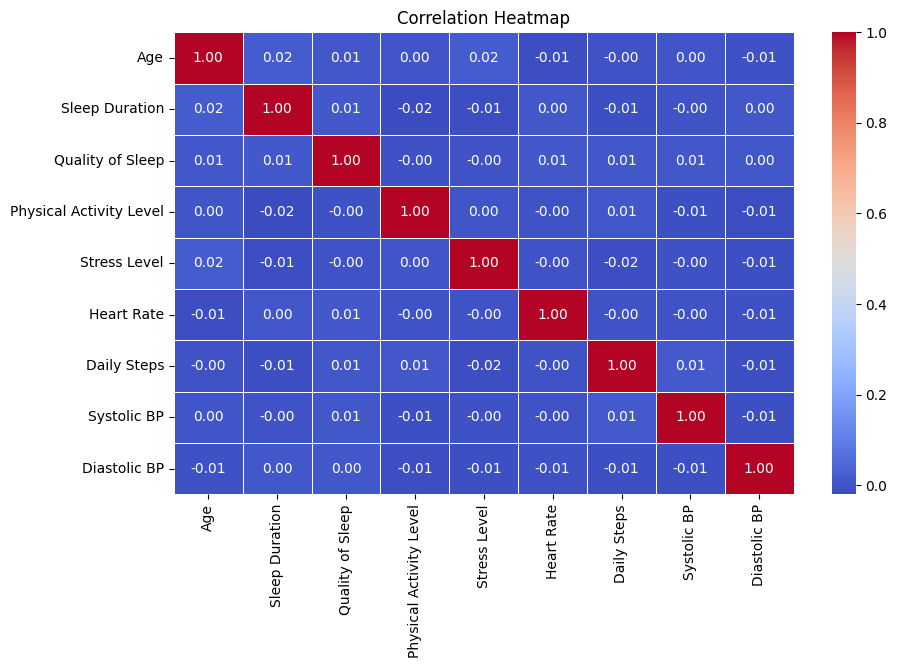

Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}

Random Forest Performance After Tuning:
MAE: 0.0006323255822251294
MSE: 0.00040669478788856844
R2 Score: 0.9997296245263115
Cross-Validation R2 Scores: [0.99997119 0.99999226 0.99995346 0.99970957 0.99971302]
Mean CV R2 Score: 0.9998678988247715

Feature Importance:
                       Feature    Importance
8            Sleep_Consistency  7.411045e-01
1               Sleep Duration  2.588870e-01
0                          Age  4.107410e-06
4      Physical Activity Level  2.019756e-06
9  Activity_Stress_Interaction  1.544639e-06
7                  Daily Steps  8.776359e-07
2                  Systolic BP  0.000000e+00
3                 Diastolic BP  0.000000e+00
5                 Stress Level  0.000000e+00
6                   Heart Rate  0.000000e+00

Performance on Completely Unseen Data:
MAE: 0.0007444419065022082
MSE: 0.00014745960153537827
R2 Score: 0.9998940585139757


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
df=pd.read_csv("modified_sleep_dataset.csv")

# Data Exploration
print("First 5 rows of dataset:")
print(df.head())

print("\nDataset Information:")
print(df.info())

print("\nSummary Statistics:")
print(df.describe())

# Checking for Duplicates
duplicate_rows = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_rows}")
df = df.drop_duplicates()

# Checking for Missing Values
missing_values = df.isnull().sum()
print("\nMissing Values:\n", missing_values)

# Handling Missing Values
df.fillna(df.median(numeric_only=True), inplace=True)

# Outlier Detection & Handling using Z-score
numeric_cols = df.select_dtypes(include=[np.number]).columns
z_scores = np.abs(zscore(df[numeric_cols]))
threshold = 3
df = df[(z_scores < threshold).all(axis=1)]

# Feature Engineering
df["Sleep_Consistency"] = df["Sleep Duration"] - df["Quality of Sleep"] * 0.5
df["Activity_Stress_Interaction"] = df["Physical Activity Level"] / (df["Stress Level"] + 1)

# Data Visualization
plt.figure(figsize=(12, 6))
df[numeric_cols].hist(bins=30, figsize=(12, 8), edgecolor='black')
plt.suptitle("Histograms of Numeric Features")
plt.show()

plt.figure(figsize=(12, 6))
for col in numeric_cols:
    sns.kdeplot(df[col], label=col)
plt.title("Kernel Density Estimation (KDE) Plots")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# Model Selection and Hyperparameter Tuning
features = ["Age", "Sleep Duration", "Systolic BP","Diastolic BP","Physical Activity Level", "Stress Level", "Heart Rate", "Daily Steps", "Sleep_Consistency", "Activity_Stress_Interaction"]
target = "Quality of Sleep"

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grids_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='r2', n_jobs=-1)
grids_search.fit(X_train, y_train)

best_rf = grids_search.best_estimator_
print(f"Best parameters: {grids_search.best_params_}")

# Model Evaluation
y_pred = best_rf.predict(X_test)
print("\nRandom Forest Performance After Tuning:")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"R2 Score: {r2_score(y_test, y_pred)}")

# Cross-Validation
cv_scores = cross_val_score(best_rf, X, y, cv=5, scoring='r2')
print(f"Cross-Validation R2 Scores: {cv_scores}")
print(f"Mean CV R2 Score: {np.mean(cv_scores)}")

# Feature Importance Analysis
feature_importances = best_rf.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(importance_df)

# Testing on Completely Unseen Data (Simulated by holding out 10% of original dataset)
X_train_final, X_holdout, y_train_final, y_holdout = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
best_rf.fit(X_train_final, y_train_final)
y_holdout_pred = best_rf.predict(X_holdout)
print("\nPerformance on Completely Unseen Data:")
print(f"MAE: {mean_absolute_error(y_holdout, y_holdout_pred)}")
print(f"MSE: {mean_squared_error(y_holdout, y_holdout_pred)}")
print(f"R2 Score: {r2_score(y_holdout, y_holdout_pred)}")


In [1]:
import joblib


joblib.dump(best_rf, 'model.pkl')


NameError: name 'best_rf' is not defined

In [6]:
import pickle

# List of features IN THE EXACT ORDER used for training
features = [
    'Age',
    'Sleep Duration', 
    'Systolic BP',
    'Diastolic BP',
    'Physical Activity Level',
    'Stress Level',
    'Heart Rate',
    'Daily Steps',
    'Sleep_Consistency',           # Your engineered feature
    'Activity_Stress_Interaction'  # Your engineered feature
]

# Save the feature list
with open('model_features.pkl', 'wb') as f:
    pickle.dump(features, f)

In [11]:
pip install streamlit

     ---------------------------------------- 9.8/9.8 MB 3.9 MB/s eta 0:00:00
  Using cached altair-5.5.0-py3-none-any.whl (731 kB)
     -------------------------------------- 434.5/434.5 kB 6.7 MB/s eta 0:00:00
     ---------------------------------------- 25.3/25.3 MB 3.7 MB/s eta 0:00:00
  Using cached requests-2.32.3-py3-none-any.whl (64 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl (16 kB)
  Using cached watchdog-6.0.0-py3-none-win_amd64.whl (79 kB)
     -------------------------------------- 207.6/207.6 kB 6.4 MB/s eta 0:00:00
  Using cached pydeck-0.9.1-py2.py3-none-any.whl (6.9 MB)
  Using cached jsonschema-4.23.0-py3-none-any.whl (88 kB)
     ------------------------------------- 325.5/325.5 kB 19.7 MB/s eta 0:00:00
     ---------------------------------------- 62.8/62.8 kB ? eta 0:00:00
     -------------------------------------- 102.4/102.4 kB 6.1 MB/s eta 0:00:00
  Using cached idna-3.10-py3-none-any.whl (70 kB)
     ---------------------------------------- 128.7/128.


[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import streamlit as st
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import pickle

# Load the trained model and scaler
@st.cache_resource
def load_model():
    # Load your model and scaler here
    # For this example, I'll create dummy ones - replace with your actual model loading code
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    scaler = StandardScaler()
    return model, scaler

model, scaler = load_model()

# Define mappings (same as in your original code)
occupation_mapping = {
    'Software Engineer': 0, 'Doctor': 1, 'Sales Representative': 2, 'Teacher': 3,
    'Nurse': 4, 'Engineer': 5, 'Accountant': 6, 'Scientist': 7, 'Lawyer': 8,
    'Salesperson': 9, 'Manager': 10, 'Student': 11, 'Athlete': 12, 'Artist': 13
}

gender_mapping = {'Female': 0, 'Male': 1}

# BMI calculation functions
def calculate_bmi(weight, height):
    bmi = weight / (height ** 2)
    return bmi

def get_bmi_category(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif 18.5 <= bmi < 25:
        return "Normal"
    else:
        return "Overweight"

# Sleep disorder prediction
def predict_sleep_disorder(quality_of_sleep, stress_level, sleep_duration):
    if quality_of_sleep < 4 or (stress_level > 7 and sleep_duration < 5):
        return "🚨 High risk of sleep disorder (e.g., insomnia, sleep apnea). Consult a specialist."
    elif quality_of_sleep < 6:
        return "⚠️ Moderate risk of developing a sleep disorder. Consider improving sleep hygiene."
    else:
        return "✅ Low risk of sleep disorder. Maintain healthy sleep habits."

# Personalized sleep suggestions (same as your original function)
def generate_sleep_suggestions(quality_of_sleep, sleep_duration, stress_level, physical_activity, 
                              age, occupation, bmi_category, heart_rate, systolic_bp, diastolic_bp):
    report = f"\n🔹 **Predicted Quality of Sleep: {quality_of_sleep:.1f}/10**\n\n"
    report += "### 🌜 Sleep Analysis Report\n"

    # Sleep duration analysis
    report += f"- **Sleep Duration:** {sleep_duration} hours "
    if sleep_duration < 6:
        report += "(⚠️ Below recommended 7-9 hours)\n"
    elif sleep_duration > 9:
        report += "(⚠️ Above recommended amount)\n"
    else:
        report += "(✅ Optimal duration)\n"
    
    # Sleep quality assessment
    report += "\n### 🛌 Quality Assessment\n"
    if quality_of_sleep >= 8:
        report += "- 🌟 Excellent! You're getting restorative sleep\n"
    elif quality_of_sleep >= 6:
        report += "- 👍 Good, but room for improvement\n"
    else:
        report += "- 😟 Needs improvement for better health\n"
    
    # Personalized recommendations section
    report += "\n### 💡 Personalized Recommendations\n"

    # Sleep duration improvement
    if sleep_duration < 6:
        report += "- 🕘 **Go to bed earlier**: Aim for 7-9 hours nightly\n"
        if occupation in [11, 5]:  # Student or Engineer
            report += "  - As a busy professional, try power naps (20-30 mins) to supplement\n"
    
    # Stress management
    if stress_level > 6:
        report += "- 🧘 **Stress reduction**: Try these before bed:\n"
        report += "  - 4-7-8 breathing technique (inhale 4s, hold 7s, exhale 8s)\n"
        report += "  - Progressive muscle relaxation\n"
        if age > 50:
            report += "  - Gentle yoga or tai chi can be especially helpful\n"
    
    # Physical activity recommendations
    if physical_activity < 4:
        report += "- 🏃 **Move more**: Aim for at least 30 mins daily activity\n"
        report += "  - Morning walks help regulate circadian rhythm\n"
    elif physical_activity > 7:
        report += "- ⏰ **Timing matters**: Avoid intense workouts within 3 hours of bedtime\n"
    
    # Occupation-based suggestions
    if occupation in [1, 4]:  # Doctor or Nurse
        report += "- ⚕️ **For healthcare workers**:\n"
        report += "  - Maintain consistent sleep schedule even on days off\n"
        report += "  - Use blackout curtains for daytime sleeping\n"
    
    # BMI-related suggestions
    if bmi_category in ["Overweight"]:
        report += "- 🍏 **Weight management**:\n"
        report += "  - Avoid heavy meals before bedtime\n"
        report += "  - Consider sleep apnea screening if you snore\n"
    
    # Heart rate recommendations
    if heart_rate > 80:
        report += "- ❤️ **Heart health**:\n"
        report += "  - Evening meditation may help lower resting heart rate\n"

    # Blood pressure considerations
    if systolic_bp > 130 or diastolic_bp > 85:
        report += "- 💓 **Blood Pressure Alert:**\n"
        report += "  - High BP can disrupt sleep. Reduce salt intake and manage stress.\n"

    # General sleep hygiene
    report += "\n### 🌙 Universal Sleep Tips\n"
    report += "- 📵 Create a tech-free zone 1 hour before bed\n"
    report += "- 🌡️ Keep bedroom temperature between 60-67°F (15-19°C)\n"
    report += "- 🛏️ Reserve bed only for sleep (no work or TV)\n"

    # Morning routine suggestions
    report += "\n### ☀️ Morning Boosters\n"
    report += "- Open curtains immediately upon waking\n"
    if quality_of_sleep < 6:
        report += "- Consider a dawn simulator alarm clock\n"

    # Final encouragement
    report += "\n💬 Remember: Small consistent changes make the biggest difference!"
    
    return report

# Streamlit UI
st.title("🌙 Sleep Quality Predictor & Health Advisor")
st.markdown("""
This app predicts your sleep quality based on your lifestyle factors and provides personalized recommendations 
to improve your sleep health.
""")

# User input form
with st.form("user_input_form"):
    st.header("Personal Information")
    col1, col2 = st.columns(2)
    with col1:
        gender = st.selectbox("Gender", ["Female", "Male"])
    with col2:
        age = st.number_input("Age", min_value=1, max_value=120, value=30)
    
    occupation = st.selectbox("Occupation", list(occupation_mapping.keys()))
    
    st.header("Sleep & Activity")
    sleep_duration = st.slider("Sleep Duration (hours)", 1.0, 12.0, 7.0, 0.5)
    physical_activity = st.slider("Physical Activity Level (0-10)", 0, 10, 5)
    stress_level = st.slider("Stress Level (1-10)", 1, 10, 5)
    daily_steps = st.number_input("Daily Steps", min_value=0, value=8000)
    
    st.header("Health Metrics")
    col1, col2 = st.columns(2)
    with col1:
        weight = st.number_input("Weight (kg)", min_value=30.0, max_value=200.0, value=70.0)
    with col2:
        height = st.number_input("Height (cm)", min_value=100, max_value=250, value=170)
    
    col1, col2 = st.columns(2)
    with col1:
        systolic_bp = st.number_input("Systolic BP", min_value=80, max_value=200, value=120)
    with col2:
        diastolic_bp = st.number_input("Diastolic BP", min_value=50, max_value=150, value=80)
    
    heart_rate = st.number_input("Heart Rate (BPM)", min_value=40, max_value=150, value=72)
    
    submitted = st.form_submit_button("Predict Sleep Quality")

# Process when form is submitted
if submitted:
    # Calculate BMI
    height_m = height / 100
    bmi = calculate_bmi(weight, height_m)
    bmi_category = get_bmi_category(bmi)
    
    # Prepare input for model
    user_input = {
        'Gender': gender_mapping[gender],
        'Age': age,
        'Occupation': occupation_mapping[occupation],
        'Sleep Duration': sleep_duration,
        'Physical Activity Level': physical_activity,
        'Stress Level': stress_level,
        'Systolic BP': systolic_bp,
        'Diastolic BP': diastolic_bp,
        'Heart Rate': heart_rate,
        'Daily Steps': daily_steps
    }
    
    # Convert to DataFrame and scale
    input_df = pd.DataFrame([user_input])
    input_scaled = scaler.transform(input_df)
    
    # Predict sleep quality
    predicted_quality = model.predict(input_scaled)[0]
    
    # Display results
    st.success("Analysis Complete!")
    
    # BMI Results
    st.subheader("📊 BMI Results")
    col1, col2 = st.columns(2)
    with col1:
        st.metric("BMI Value", f"{bmi:.1f}")
    with col2:
        st.metric("BMI Category", bmi_category)
    
    # Sleep Quality Prediction
    st.subheader("🌙 Sleep Quality Prediction")
    st.metric("Predicted Sleep Quality (1-10)", f"{predicted_quality:.1f}")
    
    # Sleep Disorder Risk
    disorder_risk = predict_sleep_disorder(predicted_quality, stress_level, sleep_duration)
    st.subheader("🚨 Sleep Disorder Risk Assessment")
    st.info(disorder_risk)
    
    # Personalized Recommendations
    st.subheader("💡 Personalized Sleep Recommendations")
    suggestions = generate_sleep_suggestions(
        predicted_quality, sleep_duration, stress_level, physical_activity,
        age, occupation_mapping[occupation], bmi_category, heart_rate,
        systolic_bp, diastolic_bp
    )
    
    # Display the markdown content
    st.markdown(suggestions, unsafe_allow_html=True)
    
    # Additional tips
    st.subheader("📚 Additional Resources")
    st.markdown("""
    - [National Sleep Foundation Guidelines](https://www.sleepfoundation.org/)
    - [CDC Sleep and Health](https://www.cdc.gov/sleep/index.html)
    - [Mindfulness Meditation for Sleep](https://www.headspace.com/sleep)
    """)


  




2025-04-11 18:24:41.163 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-11 18:24:41.166 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-11 18:24:41.170 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-11 18:24:41.173 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-11 18:24:41.176 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-11 18:24:41.179 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-11 18:24:41.179 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-11 18:24:41.182 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator(_root_container=1, _parent=DeltaGenerator(_form_data=FormData(form_id='user_input_form')))